In [1]:
import torch

device = torch.device("cuda:1")
# data = torch.load("/data/lliu/huffman/layer_0_self_attn.q_proj.pt")
data = torch.load("/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/hessians/pajama/128/layer_3/self_attn.q_proj.pt")
W = data["weight"].to(device).to(torch.float32)
# W_error = torch.load("../test/remaining_W_error.pt").detach().to(device)
# W_trunc = W[4096:4096*2,:]

data = torch.load("/data/lliu/huffman/layer_0_self_attn.q_proj.pt")
W_q = data["weight"].to(device).to(torch.float32)

/tmp/ipykernel_1475955/419236866.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("/data/lliu/huffman/models/meta-llama/Llama-2-7b-hf/hessians/pajama/12

In [2]:
U,S_mlp,V = torch.svd(W,compute_uv=True)
# _,S_trunc,_ = torch.svd(W_trunc,compute_uv=True)
U_q,S_q,V_q = torch.svd(W_q,compute_uv=True)

In [83]:
norms_0 = torch.norm(W_trunc, dim=0)
norms_1 = torch.norm(W_trunc, dim=1)

zero_out_top = 0.1

def find_threshold(W, zero_out_top:float,eps=1e-6):
    
    threshold = torch.mean(W)
    search_range = [0,torch.max(W)]
    #perform binary search to find the threshold
    for i in range(100):
        mask = W > threshold
        n_zeros = torch.sum(mask).item()
        print(threshold, n_zeros, int(zero_out_top*W.numel()))
        if n_zeros > int(zero_out_top*W.numel()) + 1:
            search_range[0] = threshold
            threshold_ = (search_range[0] + search_range[1])/2
        elif n_zeros < int(zero_out_top*W.numel())-1:
            search_range[1] = threshold
            threshold_ = (search_range[0] + search_range[1])/2
        
        if abs(threshold-threshold_) < eps:
            break
        threshold = threshold_
    return threshold



In [84]:
#try unstructured sparsity
W_trunc_sparse = W_trunc.clone()

# threshold = torch.quantile(torch.abs(W_trunc), 1-zero_out_top)
# print(threshold)
threshold = find_threshold(torch.abs(W_trunc), zero_out_top)
# print(threshold)

mask = torch.abs(W_trunc_sparse) > threshold
W_trunc_sparse[mask] = 0


tensor(0.0130, device='cuda:1') 7069598 1677721
tensor(0.4518, device='cuda:1') 5 1677721
tensor(0.2324, device='cuda:1') 58 1677721
tensor(0.1227, device='cuda:1') 1095 1677721
tensor(0.0678, device='cuda:1') 7313 1677721
tensor(0.0404, device='cuda:1') 248033 1677721
tensor(0.0267, device='cuda:1') 1700117 1677721
tensor(0.0335, device='cuda:1') 681185 1677721
tensor(0.0301, device='cuda:1') 1097070 1677721
tensor(0.0284, device='cuda:1') 1371151 1677721
tensor(0.0275, device='cuda:1') 1528349 1677721
tensor(0.0271, device='cuda:1') 1600179 1677721
tensor(0.0269, device='cuda:1') 1649385 1677721
tensor(0.0268, device='cuda:1') 1674603 1677721
tensor(0.0267, device='cuda:1') 1674603 1677721
tensor(0.0267, device='cuda:1') 1700117 1677721
tensor(0.0267, device='cuda:1') 1700117 1677721
tensor(0.0267, device='cuda:1') 1700117 1677721
tensor(0.0267, device='cuda:1') 1674603 1677721
tensor(0.0267, device='cuda:1') 1674603 1677721


In [85]:

_,S_trunc_sparse,_ = torch.svd(W_trunc_sparse,compute_uv=True)

In [86]:
W_error_use = W_error.clone()
_,S_error0,_ = torch.svd(W_error_use,compute_uv=True)
W_error_use = W_error[:4096,:]
norm_0 = torch.norm(W_error_use, dim=0, p = 1)
W_error_use = W_error_use / norm_0.unsqueeze(0)
norm_1 = torch.norm(W_error_use, dim=1, p = 1)
W_error_use = W_error_use / norm_1.unsqueeze(1)


_,S_error,_ = torch.svd(W_error_use,compute_uv=True)

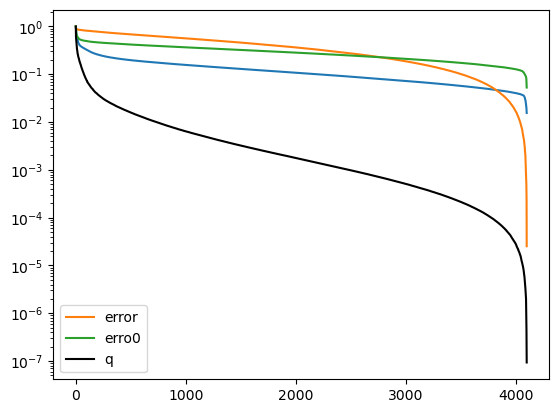

In [ ]:
import matplotlib.pyplot as plt
plt.plot(S_mlp.cpu().numpy()/S_mlp[0].item())
# plt.plot(S_trunc.cpu().numpy()/S_trunc[0].item())
# plt.plot(S_trunc_sparse.cpu().numpy()/S_trunc_sparse[0].item(), label="sparse")
# plt.plot(S_error.cpu().numpy()/S_error[0].item(), label="error")
# plt.plot(S_error0.cpu().numpy()/S_error0[0].item(), label="erro0")
plt.plot(S_q.cpu().numpy()/S_q[0].item(), label="q",color= "black")
plt.legend()
plt.yscale("log")

In [68]:
U_trunc_sparse,S_trunc_sparse,V_trunc_sparse = torch.svd(W_trunc_sparse,compute_uv=True)

A = U_q @ torch.diag(torch.sqrt(S_q))
B = 

SyntaxError: invalid syntax (2713136772.py, line 4)

In [ ]:

rank = 1000

A = U_trunc_sparse[:,:rank] @ torch.diag(torch.sqrt(S_trunc_sparse[:rank]))
B = V_trunc_sparse[:,:rank] @ torch.diag(torch.sqrt(S_trunc_sparse[:rank]))

reconstruct_W = A @ B.T
reconstruct_W[mask] = W_trunc[mask]

print(reconstruct_W)

tensor([[ 1.2679e-04, -6.9337e-06, -1.1495e-05,  ...,  0.0000e+00,
          1.8550e-04, -1.3799e-04],
        [ 7.2013e-05, -1.6797e-04, -1.0342e-04,  ...,  0.0000e+00,
         -9.1990e-05,  6.4335e-05],
        [-2.3593e-04, -1.9925e-04, -1.8707e-04,  ...,  0.0000e+00,
         -2.3770e-05, -4.5021e-04],
        ...,
        [ 3.9864e-04,  2.2429e-04, -7.7839e-05,  ...,  0.0000e+00,
          1.7465e-04,  4.3944e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.1826e-04,  5.0470e-04, -3.5682e-05,  ...,  0.0000e+00,
          1.0765e-04, -4.4392e-05]], device='cuda:1')


In [37]:
torch.nn.functional.mse_loss(W_trunc, reconstruct_W)/\
    torch.mean(W_trunc**2)

tensor(0.9768, device='cuda:1')

In [38]:
sparse_tensor = W_trunc.clone()
sparse_tensor[~mask] = 0
sparse_tensor = sparse_tensor.to_sparse()
sparse_tensor = sparse_tensor.to_sparse_csr().to(torch.float16)
# sparse_tensor = sparse_tensor.coalesce()
sparse_tensor

/tmp/ipykernel_1276474/461193472.py:4: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  sparse_tensor = sparse_tensor.to_sparse_csr().to(torch.float16)


tensor(crow_indices=tensor([   0,   12,   13,  ..., 8143, 8143, 8143]),
       col_indices=tensor([  88,  210,  473,  ..., 2780, 3704, 3894]),
       values=tensor([-0.0864,  0.0894,  0.0815,  ..., -0.0708,  0.0718,
                       0.0669]), device='cuda:1', size=(4096, 4096), nnz=8143,
       dtype=torch.float16, layout=torch.sparse_csr)

In [45]:
import numpy as np
def get_n_bits_csr(csr_sparse_tensor):
    
    nse = csr_sparse_tensor.crow_indices()[-1]
    nrows = csr_sparse_tensor.crow_indices().shape[0] - 1
    n_indicies_bits = torch.ceil(torch.log2(max(nse, nrows)))
    return ((nrows * n_indicies_bits + (n_indicies_bits + 16)*nse)).item()

get_n_bits_csr(sparse_tensor)/W_trunc.numel()
    
    

0.33530914783477783

In [49]:
sparse_tensor.crow_indices()[-1]

tensor(163289, device='cuda:1')

In [50]:
torch.sum(mask)

tensor(163289, device='cuda:1')

In [23]:
sparse_tensor = torch.sparse_coo_tensor(
    [torch.where(mask)[0], torch.where(mask)[1]],
    W_trunc_sparse[mask],
    size = W_trunc_sparse.shape
)
sparse_tensor = sparse_tensor.to_sparse_csr().to(torch.float16)
sparse_tensor

TypeError: only integer tensors of a single element can be converted to an index

In [17]:
W_trunc_sparse[mask].shape

torch.Size([163289])

In [20]:
[torch.where(mask)[0].shape, torch.where(mask)[1].shape]

[torch.Size([163289]), torch.Size([163289])]

In [13]:
coo_tensor = torch.sparse_coo_tensor(
    indices=torch.tensor([[0, 1, 2], [1, 0, 2]]),
    values=torch.tensor([3, 4, 5]),
    size=(3, 3)
)
coo_tensor.to_dense()

tensor([[0, 3, 0],
        [4, 0, 0],
        [0, 0, 5]])